In [162]:
import cv2
import mediapipe as mp
import csv
import pandas_ta as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from pykalman import KalmanFilter

In [11]:
video_path = './Data/videos/20240301_173556.mp4'
output_csv = './output'

In [29]:
## initialize pose estimator
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.3, min_tracking_confidence=0.3, model_complexity = 2)

In [4]:
cap = cv2.VideoCapture(video_path)
res = []
while cap.isOpened():
    # read frame
    _, frame = cap.read()
    try:
         # resize the frame for portrait video
         frame = frame#[0:1440,3840-2560:3840]
         #frame = cv2.resize(frame, (1280, 720))
         # convert to RGB
         frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
         
         # process the frame for pose detection
         pose_results = pose.process(frame_rgb)
         # print(pose_results.pose_landmarks)
         res.append(pose_results)
         
         # draw skeleton on the frame
         mp_drawing.draw_landmarks(frame, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
         # display the frame
         cv2.imshow('Output', cv2.resize(frame, (1280, 720)))
    except:
         break
    
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
    if key == ord('p'):
        cv2.waitKey(-1) #wait until any key is pressed
    
    
          
cap.release()
cv2.destroyAllWindows()

In [5]:
print(res[240].pose_landmarks.landmark[32])

x: 0.048257772
y: 0.56773263
z: 0.035561647
visibility: 0.92141587



In [64]:

df = pd.DataFrame(columns=["x", "y"])
fps = 60  # Frame rate of the video
frame_count = 0
for results in resFull:
    if results.pose_landmarks:
            # Get the landmark for the left knee.
            left_knee = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ANKLE]
            #df = df.append({"x": left_knee.x, "y": left_knee.y}, ignore_index=True)
            # Calculate the timestamp.
            time = frame_count / fps
            # Append the coordinates and time to the DataFrame.
            df = pd.concat([df, pd.DataFrame([{'time': time, 'x': left_knee.x, 'y' : left_knee.y}])], ignore_index=True)
            #new_row = pd.DataFrame({"x": [left_knee.x], "y": [left_knee.y]})
            #df = pd.concat([df, new_row], ignore_index=True)
            frame_count +=1
df['xDeriv'] = df['x'].diff()
df["xMA"] = df['x'].rolling(window=6).mean().shift(-3)
df['xMADeriv'] = df['xMA'].diff()

C:\Users\friha\AppData\Local\Temp\ipykernel_20924\2072547219.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([{'time': time, 'x': left_knee.x, 'y' : left_knee.y}])], ignore_index=True)


234


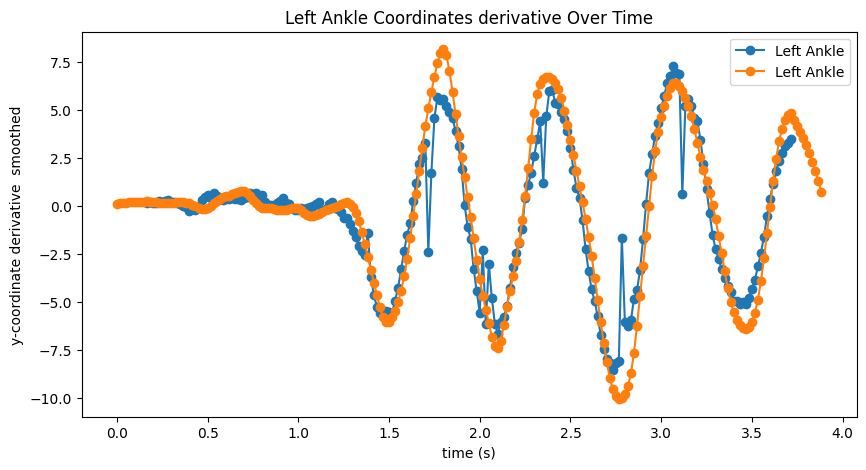

In [183]:
# Plot the coordinates.
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['y'].rolling(window=20).mean().shift(-10).diff(), 'o-', label='Left Ankle')
df["yDeriv"] = df['y'].diff().fillna(0)
print(len(df["yDeriv"]))
df["smoothed"] = lowess(df['yDeriv'], df['time'], frac=0.095, it=1)[:, 1]

kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
smoothed_left, _ = kf.smooth(df['yDeriv'].values.reshape(-1, 1))

df['smoothed_kalman'] = smoothed_left.flatten()

plt.plot(df['time'], df['smoothed'], 'o-', label='Left Ankle')
#plt.plot(df['time'], df['smoothed_kalman'], 'o-', label='Left Ankle')
plt.ylabel('y-coordinate derivative  smoothed')
plt.xlabel('time (s)') #╠y-coordinate (normalized)')
plt.title('Left Ankle Coordinates derivative Over Time')
plt.legend()
plt.show()

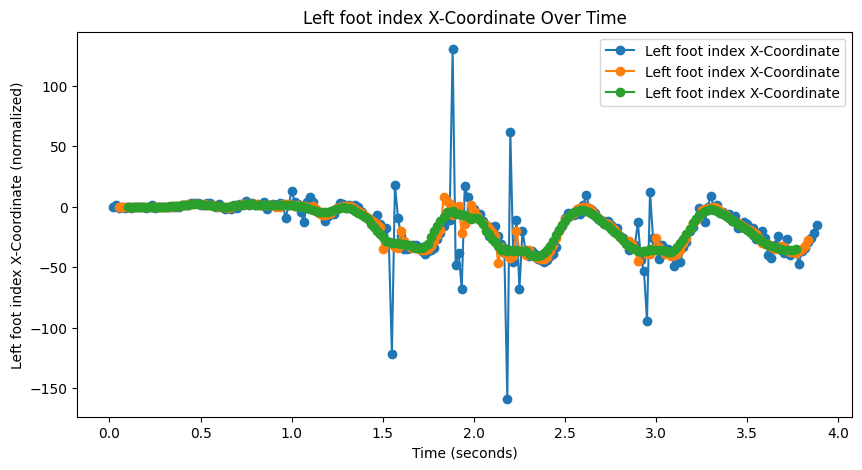

In [115]:
# Plot the coordinates.
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['xDeriv'], 'o-', label='Left foot index X-Coordinate')
plt.plot(df['time'], df['xMADeriv'], 'o-', label='Left foot index X-Coordinate')
plt.plot(df['time'], df['xMADeriv'].rolling(window=8).mean().shift(-4), 'o-', label='Left foot index X-Coordinate')
plt.xlabel('Time (seconds)')
plt.ylabel('Left foot index X-Coordinate (normalized)')
plt.title('Left foot index X-Coordinate Over Time')
plt.legend()
plt.show()

In [4]:
import cv2
import numpy as np
from ultralytics import YOLO
from collections import deque

# Initialize YOLOv8 model
model = YOLO('yolov8s.pt')  # You can replace 'yolov8s.pt' with the path to your YOLOv8 model

def detect_persons(frame):
    results = model(frame, conf = 0.1)
    person_boxes = []
    
    for result in results[0].boxes:
        x1, y1, x2, y2 = map(int, result.xyxy[0])
        cls = int(result.cls)
        if cls == 0:  # Class ID 0 is for 'person'
            person_boxes.append((x1, y1, x2 - x1, y2 - y1))
    
    return person_boxes

def calculate_horizontal_velocity(current_positions, previous_positions):
    velocities = {}
    for i in current_positions:
        if i in previous_positions:
            velocities[i] = abs(current_positions[i][0] - previous_positions[i][0])
        
    return velocities



def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    #tracker = cv2.TrackerKCF_create()
    prev_positions = {}
    max_velocity = 0
    bbox_highest_velocity = None

    tracks = {}
    track_id = 0
    max_velocity_track_id = None
    frames_buffer = 6000  # Number of frames to keep for each track
    i = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Detect persons in the frame
        person_boxes = detect_persons(frame)
        

        # Track each person
        current_positions = {}
        for box in person_boxes:
            x, y, w, h = box
            center_x = x + w / 2
            center_y = y + h / 2
            if i < 60:
                print("hiii======")
                print(box)
                print("========")
            

            # Find if this is a new track or existing one
            found = False
            for trackid, (prev_center_x, prev_center_y, track) in tracks.items():
                print("false")
                print(prev_center_x, prev_center_y, trackid)
                if abs(center_x - prev_center_x) < w and abs(center_y - prev_center_y) < h:
                    print("changed in track id ", trackid, )
                    found = True
                    current_positions[trackid] = (center_x, box)
                    tracks[trackid] = (center_x, center_y, track + [[x,y,w,h]])
                    break

            if not found:
                temp = list([[x,y,w,h]])
                tracks[track_id] = (center_x, center_y, temp)#deque(maxlen=frames_buffer))
                current_positions[track_id] = (center_x, box)
                print("track id ", track_id)
                track_id += 1
                

        velocities = calculate_horizontal_velocity(current_positions, prev_positions)
        for trackid, velocity in velocities.items():
            if velocity > max_velocity:
                print("happened ", velocity, " track id  ", trackid)
                max_velocity = velocity
                max_velocity_track_id = trackid
                bbox_highest_velocity = current_positions[trackid][1]

        prev_positions = current_positions
        

            
        i += 1

        # Draw bounding boxes and track IDs
        for track_id, (center_x, center_y, track) in tracks.items():
            if track_id in current_positions:
                box = current_positions[track_id][1]
                x, y, w, h = box
                cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
                cv2.putText(frame, f"ID: {track_id}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        cv2.imshow('Frame', cv2.resize(frame, (1280, 720)))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    return bbox_highest_velocity, max_velocity_track_id, tracks

# Example usage
#video_path = "path_to_your_video.mp4"
bbox, id, tracks = process_video(video_path)
print("Bounding box of the person with highest horizontal velocity:", bbox)




0: 384x640 3 persons, 1 sports ball, 2 skateboards, 411.0ms
Speed: 17.3ms preprocess, 411.0ms inference, 2726.0ms postprocess per image at shape (1, 3, 384, 640)
hiii======
(3297, 1086, 267, 278)
track id  0
hiii======
(1492, 1774, 418, 385)
false
3430.5 1225.0 0
track id  1
hiii======
(1984, 1751, 540, 406)
false
3430.5 1225.0 0
false
1701.0 1966.5 1
track id  2

0: 384x640 3 persons, 1 sports ball, 1 skateboard, 266.0ms
Speed: 4.8ms preprocess, 266.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)
hiii======
(3297, 1086, 268, 279)
false
3430.5 1225.0 0
changed in track id  0
hiii======
(1491, 1774, 421, 385)
false
3431.0 1225.5 0
false
1701.0 1966.5 1
changed in track id  1
hiii======
(1982, 1752, 542, 404)
false
3431.0 1225.5 0
false
1701.5 1966.5 1
false
2254.0 1954.0 2
changed in track id  2
happened  0.5  track id   0
happened  1.0  track id   2

0: 384x640 3 persons, 2 sports balls, 1 skateboard, 237.1ms
Speed: 4.0ms preprocess, 237.1ms inference, 5.2ms postp

In [5]:
def calculate_max_horizontal_velocity(dataset):
    if not dataset:
        return None

    # Extract all x-coordinates
    x_coords = [box[0] for box in dataset]

    # Calculate max and min x-coordinates
    max_x = max(x_coords)
    min_x = min(x_coords)

    # Calculate horizontal velocity
    horizontal_velocity = max_x - min_x

    # Find the bounding box with the max x-coordinate
    max_x_box = next(box for box in dataset if box[0] == max_x)

    return max_x_box, horizontal_velocity

In [6]:
def find_max_velocity(velocity_dict):
    if not velocity_dict:
        return None

    # Find the ID with the maximum velocity
    max_id = max(velocity_dict, key=velocity_dict.get)
    max_velocity = velocity_dict[max_id]

    return max_id, max_velocity

In [7]:
velocities = {}
for i in tracks:
    box, v = calculate_max_horizontal_velocity(tracks[i][2])
    velocities[i] = v
    
max_velocity_id, max_velocity = find_max_velocity(velocities)
print(tracks.keys())
print(tracks[max_velocity_id][2], max_velocity)


dict_keys([0, 1, 2])
[[3297, 1086, 267, 278], [3297, 1086, 268, 279], [3298, 1087, 267, 277], [3297, 1087, 268, 277], [3297, 1087, 269, 278], [3297, 1087, 268, 277], [3297, 1087, 267, 277], [3297, 1087, 268, 277], [3297, 1087, 268, 276], [3297, 1087, 268, 277], [3297, 1087, 267, 276], [3297, 1088, 267, 276], [3296, 1088, 267, 276], [3296, 1088, 267, 276], [3297, 1089, 267, 274], [3296, 1088, 266, 275], [3296, 1089, 266, 273], [3296, 1089, 266, 273], [3296, 1089, 267, 273], [3296, 1090, 267, 271], [3295, 1090, 270, 272], [3295, 1091, 271, 272], [3294, 1090, 276, 271], [3293, 1090, 279, 268], [3293, 1092, 281, 268], [3291, 1092, 278, 268], [3288, 1094, 283, 270], [3287, 1096, 279, 265], [3287, 1097, 280, 258], [3286, 1098, 283, 260], [3285, 1098, 283, 256], [3285, 1099, 281, 255], [3283, 1098, 284, 254], [3282, 1097, 290, 258], [3282, 1093, 292, 257], [3281, 1093, 289, 262], [3282, 1091, 292, 264], [3283, 1091, 294, 263], [3284, 1090, 297, 262], [3284, 1086, 291, 266], [3284, 1085, 292, 

In [9]:
cap = cv2.VideoCapture(video_path)
res = []
index = 0
while cap.isOpened():
    # read frame
    _, frame = cap.read()
    try:
         x_strart = tracks[max_velocity_id][2][index][0] - 300
         x_end = tracks[max_velocity_id][2][index][0] + tracks[max_velocity_id][2][index][2] + 200
         y_start = tracks[max_velocity_id][2][index][1] - 200
         y_end = tracks[max_velocity_id][2][index][1] + tracks[max_velocity_id][2][index][3] + 200
         # resize the frame for portrait video
         frame = frame#[0:1440,3840-2560:3840]
         croped_frame = frame[y_start:y_end, x_strart:x_end]
         index+=1
         #frame = cv2.resize(frame, (1280, 720))
         # convert to RGB
         frame_rgb = cv2.cvtColor(croped_frame, cv2.COLOR_BGR2RGB)
         
         # process the frame for pose detection
         pose_results = pose.process(frame_rgb)
         # print(pose_results.pose_landmarks)
         res.append(pose_results)
         for landmark in pose_results.pose_landmarks.landmark:
             print(landmark)
         # draw skeleton on the frame
         #mp_drawing._normalized_to_pixel_coordinates(pose_results.pose_landmarks, 1280, 720)
         mp_drawing.draw_landmarks(croped_frame, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
         # display the frame
         frame[y_start:y_end, x_strart:x_end] = croped_frame
         cv2.imshow('Output', cv2.resize(frame, (1280, 720))) #cv2.resize(croped_frame, (1280, 720)))
    except:
         break
    
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
    if key == ord('p'):
        cv2.waitKey(-1) #wait until any key is pressed
    
    
          
cap.release()
cv2.destroyAllWindows()

x: 0.4410497
y: 0.40210357
z: -0.2108217
visibility: 0.9993426

x: 0.42851016
y: 0.3864821
z: -0.23459968
visibility: 0.999357

x: 0.4299561
y: 0.3831924
z: -0.23505142
visibility: 0.99935776

x: 0.43128416
y: 0.38007104
z: -0.2350689
visibility: 0.9995809

x: 0.427004
y: 0.3880863
z: -0.22137482
visibility: 0.99951506

x: 0.42720452
y: 0.386095
z: -0.22163616
visibility: 0.9995628

x: 0.42718437
y: 0.3840304
z: -0.22182685
visibility: 0.9996788

x: 0.44326258
y: 0.359909
z: -0.28090712
visibility: 0.999648

x: 0.43740264
y: 0.36322224
z: -0.22105525
visibility: 0.9991024

x: 0.45663294
y: 0.3992672
z: -0.21475711
visibility: 0.99964803

x: 0.45599696
y: 0.40181637
z: -0.19998811
visibility: 0.9995265

x: 0.49983883
y: 0.40327513
z: -0.3118373
visibility: 0.9999822

x: 0.38986006
y: 0.406063
z: -0.109985285
visibility: 0.9997615

x: 0.5728579
y: 0.51935154
z: -0.3920884
visibility: 0.9815062

x: 0.47160015
y: 0.5175944
z: -0.058506314
visibility: 0.14712413

x: 0.5712345
y: 0.6305962
z

In [32]:
import cv2
import mediapipe as mp
import copy

# Initialize MediaPipe Pose and drawing modules
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Function to convert normalized coordinates to pixel coordinates
def normalized_to_pixel_coordinates(normalized_x, normalized_y, image_width, image_height):
    if 0 <= normalized_x <= 1 and 0 <= normalized_y <= 1:
        x_px = min(int(normalized_x * image_width), image_width - 1)
        y_px = min(int(normalized_y * image_height), image_height - 1)
        return x_px, y_px
    else:
        return None

# Example video path


# Load your video
cap = cv2.VideoCapture(video_path)
res = []
resFull = []  # List to store full frame pose results
index = 0

pose = mp_pose.Pose(min_detection_confidence=0.3, min_tracking_confidence=0.3, model_complexity = 2)
# Initialize pose estimation
with pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        try:
            # Define the crop region dynamically based on tracks[max_velocity_id]
            x_start = tracks[max_velocity_id][2][index][0] - 300
            x_end = tracks[max_velocity_id][2][index][0] + tracks[max_velocity_id][2][index][2] + 200
            y_start = tracks[max_velocity_id][2][index][1] - 200
            y_end = tracks[max_velocity_id][2][index][1] + tracks[max_velocity_id][2][index][3] + 200
            
            # Extract the cropped frame
            cropped_frame = frame[y_start:y_end, x_start:x_end]
            index += 1
            
            # Convert to RGB
            frame_rgb = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB)
            
            # Process the frame for pose detection
            pose_results = pose.process(frame_rgb)
            res.append(pose_results)
            
            if pose_results.pose_landmarks:
                # Deep copy the pose results to convert landmarks to full frame coordinates
                pose_results_full = copy.deepcopy(pose_results)
                
                for i, landmark in enumerate(pose_results.pose_landmarks.landmark):
                    # Convert normalized coordinates to pixel coordinates based on the cropped frame size
                    pixel_coords = normalized_to_pixel_coordinates(
                        landmark.x, landmark.y,
                        cropped_frame.shape[1], cropped_frame.shape[0]
                    )
                    
                    if pixel_coords:
                        cx, cy = pixel_coords

                        # Adjust the coordinates to the full frame
                        full_frame_x = x_start + cx
                        full_frame_y = y_start + cy

                        # Update the full frame landmarks in pose_results_full
                        pose_results_full.pose_landmarks.landmark[i].x = full_frame_x #/ frame.shape[1]
                        pose_results_full.pose_landmarks.landmark[i].y = full_frame_y #/ frame.shape[0]
                        pose_results_full.pose_landmarks.landmark[i].z = landmark.z  # z-coordinate remains unchanged

                        # Draw the landmark on the full frame
                        cv2.circle(frame, (full_frame_x, full_frame_y), 5, (0, 255, 0), -1)

                # Append the full frame pose results to the resFull list
                resFull.append(pose_results_full)
                
                # Draw landmarks on the cropped frame for visualization
                mp_drawing.draw_landmarks(cropped_frame, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
                
                # Replace the region in the full frame with the annotated cropped frame
                frame[y_start:y_end, x_start:x_end] = cropped_frame
            
            # Display the frame
            cv2.imshow('Output', cv2.resize(frame, (1280, 720)))
        
        except Exception as e:
            print(f"An error occurred: {e}")
            break
        
        key = cv2.waitKey(1)
        if key == ord('q'):
            break
        if key == ord('p'):
            cv2.waitKey(-1)  # Wait until any key is pressed

cap.release()
cv2.destroyAllWindows()


An error occurred: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'



In [97]:
       #[67.58650207519531, 111.02264404296875, 9.44921875, 4.655052185058594],  # Top-left cone (example pixel coordinates)
       #[566.5403594970703, 122.76457214355469, 9.922500610351562, 5.024871826171875], # Top-right cone (example pixel coordinates)
       #[593.4886169433594, 130.23728942871094, 10.556838989257812, 5.146728515625], # Bottom-right cone (example pixel coordinates)
       #[36.14107131958008, 117.606201171875, 11.666065216064453, 5.3371124267578125],    # Bottom-left cone (example pixel coordinates)
       #[318.36378479003906, 117.08070373535156, 8.580390930175781, 4.608123779296875] # Midpoint of the top side

def get_calibration_points():
    # Real-world coordinates in meters (example for a 10m x 1.22m segment)
    real_world_points = np.array([
        [0, 0, 0],     # Top-left cone
        [10, 0, 0],    # Top-right cone
        [10, 1.22, 0], # Bottom-right cone
        [0, 1.22, 0],  # Bottom-left cone
        [5, 0, 0],     # Midpoint of the top side
    ], dtype=np.float32)

    # Image coordinates (manually detected or using an image processing technique)
    image_points = np.array([
        [472.90, 1261.53],  # Top-left cone (example pixel coordinates)
        [3321.86, 1326.30], # Top-right cone (example pixel coordinates)
        [3475.11, 1370.99], # Bottom-right cone (example pixel coordinates)
        [301.80, 1298.35],    # Bottom-left cone (example pixel coordinates)
        [1898.15, 1292.16] # Midpoint of the top side
    ], dtype=np.float32)

    return real_world_points, image_points

In [99]:
import cv2

def calibrate_camera(real_world_points, image_points, image_size):
    # Compute homography matrix
    H, _ = cv2.findHomography(image_points, real_world_points[:, :2])
    return H


In [100]:
def detect_hip_joint(ress):
    # Dummy function: replace with actual detection logic
    # Returns coordinates of the hip joint in the image
    # e.g., using MediaPipe Pose estimation
    x = ress.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].x
    y = 1300
    return (x, y)


In [101]:
def apply_homography(H, point):
    point = np.array([point[0], point[1], 1.0])
    world_point = np.dot(H, point)
    world_point /= world_point[2]
    return world_point[:2]

def calculate_speed(positions, fps):
    velocities = []
    for i in range(1, len(positions)):
        dist = np.linalg.norm(np.array(positions[i]) - np.array(positions[i-1]))
        time = 1 / fps
        velocity = dist / time
        velocities.append(velocity)
    return velocities


In [79]:
print(resFull[0].pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].x)

3526.0


In [102]:
def process_instant_velocity( H, fps):

    positions = []

    for ress in  resFull:
        if not ress.pose_landmarks:
            break

        # Detect the athlete's hip joint in the frame
        hip_joint = detect_hip_joint(ress)
        if hip_joint:
            # Convert the detected position to real-world coordinates
            real_world_pos = apply_homography(H, hip_joint)
            positions.append(real_world_pos)

    

    # Calculate the athlete's speed
    velocities = calculate_speed(positions, fps)
    return velocities


In [104]:
def moving_average(arr, window_size):
    # Define an output array to store the moving averages
    moving_averages = np.zeros(len(arr) - window_size + 1)
    
    # Iterate over the array to compute the moving averages
    for i in range(len(arr) - window_size + 1):
        # Extract the window of values
        window = arr[i:i+window_size]
        # Calculate the average of the window
        moving_averages[i] = np.mean(window)
    
    return moving_averages

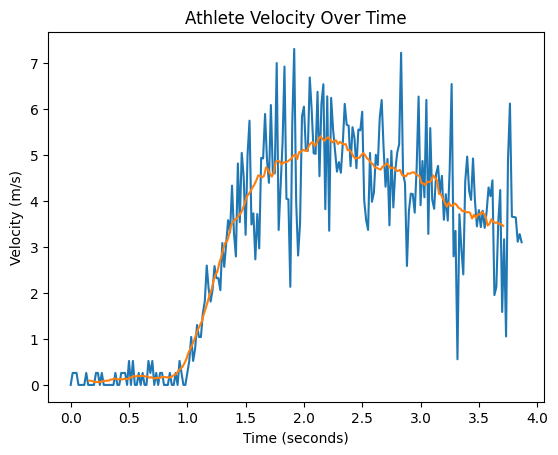

In [111]:
if __name__ == "__main__":
    real_world_points, image_points = get_calibration_points()
    image_size = (3840, 2160)  # Example image size, replace with actual
    H = calibrate_camera(real_world_points, image_points, image_size)

    #video_path = 'athlete_video.mp4'
    fps = 60  # Assuming 60 frames per second
    velocities = process_instant_velocity( H, fps)

    import matplotlib.pyplot as plt

    time_steps = np.arange(len(velocities)) / fps
    plt.plot(time_steps, velocities)
    plt.plot(moving_average(time_steps, 20), moving_average(velocities, 20))
    plt.xlabel('Time (seconds)')
    plt.ylabel('Velocity (m/s)')
    plt.title('Athlete Velocity Over Time')
    plt.show()


In [45]:
MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  x_strart = 0
  x_end = -1
  y_start = 0
  y_end = -1
  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x-100, bbox.origin_y-100
    end_point = bbox.origin_x + bbox.width+150, bbox.origin_y + bbox.height+200
    cv2.rectangle(image, start_point, end_point, TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    if category.category_name == "person":
      x_strart = bbox.origin_x-100
      x_end = bbox.origin_x + bbox.width+150
      y_start = bbox.origin_y-100
      y_end = bbox.origin_y + bbox.height+200
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x,
                     MARGIN + ROW_SIZE + bbox.origin_y)
    #cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                #FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return image[y_start:y_end, x_strart:x_end]

In [46]:
IMAGE_FILE = 'Data\Pictures\photo_2024-02-20_00-12-18.jpg'


img = cv2.imread(IMAGE_FILE)
cv2.imshow("x",img)

# waits for user to press any key 
# (this is necessary to avoid Python kernel form crashing) 
cv2.waitKey(0) 
  
# closing all open windows 
cv2.destroyAllWindows()

In [47]:
# STEP 1: Import the necessary modules.
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe.tasks.python.vision.core import vision_task_running_mode as running_mode_module
running_mode=running_mode_module.VisionTaskRunningMode.IMAGE
# STEP 2: Create an ObjectDetector object.
with open("efficientdet_lite2.tflite", "rb") as f:
    model_asset_content = f.read()
base_options = mp.tasks.BaseOptions(model_asset_buffer=model_asset_content)
options = vision.ObjectDetectorOptions(base_options=base_options,
                                       score_threshold=0.15, running_mode=running_mode_module.VisionTaskRunningMode.IMAGE, category_allowlist = ['person'])
detector = vision.ObjectDetector.create_from_options(options)
image = mp.Image.create_from_file(IMAGE_FILE)

# STEP 4: Detect objects in the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
image_copy = np.copy(image.numpy_view())
annotated_image = visualize(image_copy, detection_result)
rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
cv2.imshow('output',rgb_annotated_image)
cv2.waitKey(0) 
  
# closing all open windows 
cv2.destroyAllWindows()


cap = cv2.VideoCapture(video_path)
while cap.isOpened():
    # read frame
    _, frame = cap.read()
    try:
        image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)

        # STEP 4: Detect objects in the input image.
        detection_result = detector.detect(image)

        # STEP 5: Process the detection result. In this case, visualize it.
        image_copy = np.copy(image.numpy_view())
        annotated_image = visualize(image_copy, detection_result)
        rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
        frame = frame#[0:1440,3840-2560:3840]
         #frame = cv2.resize(frame, (1280, 720))
         # convert to RGB
        #frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
         
         # process the frame for pose detection
        pose_results = pose.process(annotated_image)
         # print(pose_results.pose_landmarks)
         
         # draw skeleton on the frame
        mp_drawing.draw_landmarks(annotated_image, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        
        #cv2.imshow('output',cv2.resize(rgb_annotated_image, (1280, 720)))
        cv2.imshow('output',  annotated_image)


    except:
         print('hii')
         break
    
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
    if key == ord('p'):
        cv2.waitKey(-1) #wait until any key is pressed
    
    
          
          
cap.release()
cv2.destroyAllWindows()

In [9]:
from ultralytics import YOLO
import numpy as np

class YOLOSegmentation:
    def init(self, model_path):
        self.model = YOLO(model_path)

    def detect(self, img):
        # Get img shape
        height, width, channels = img.shape

        results = self.model.predict(source=img.copy(), save=False, save_txt=False)
        result = results[0]
        segmentation_contours_idx = []
        bboxes = []
        class_ids = []
        scores = []
        for i, seg in enumerate(result.masks.segments):
            # contours
            seg[:, 0] *= width
            seg[:, 1] *= height
            segment = np.array(seg, dtype=np.int32)
            segmentation_contours_idx.append(segment)

            bbox = np.array(result.boxes.xyxy[i].cpu(), dtype="int")
            bboxes.append(bbox)
            # Get class ids
            class_id = np.array(result.boxes.cls[i].cpu(), dtype="int")
            class_ids.append(class_id)
            # Get scores
            score = np.array(result.boxes.conf[i].cpu(), dtype="float").round(2)
            scores.append(score)

        return bboxes, class_ids, segmentation_contours_idx, scores